In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
%cd CD_Circuit/

[Errno 2] No such file or directory: 'CD_Circuit/'
/home/shawnghu/ml/CD_Circuit/notebooks


/home/shawnghu/ml/CD_Circuit/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [12]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model

In [13]:
torch.autograd.set_grad_enabled(False)

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [14]:
print(torch.cuda.is_available())
device = 'cuda:0'

True


In [15]:
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

Loaded pretrained model gpt2-small into HookedTransformer


## Example forward pass

In [10]:
text = "After John and Mary went to the store, John gave a bottle of milk to"
tokens = model.to_tokens(text).to(device)
logits, cache = model.run_with_cache(tokens)
probs = logits.softmax(dim=-1)
most_likely_next_tokens = model.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

## Inspect model or hooks


In [ ]:
print(model.blocks[0].attn.W_Q.shape)
text = "After John and Mary went to the store, John gave a bottle of milk to"
encoding = get_encoding(text, model.tokenizer, device)
print((encoding)) #effective attrs 'input_ids' and 'attention_mask'

In [11]:
def compare_same(a, b, atol=1e-4, rtol=1e-3):
    if isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
        comparison = torch.isclose(a, b, atol, rtol)
        print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
        return
    comparison = np.isclose(a, b, atol, rtol)
    print(f"{comparison.sum()/comparison.size:.2%} of the values are correct")

# confirm what some of these hook names mean-- namely, that hook_resid_post is the output of the entire transformer block
compare_same(cache['blocks.0.hook_resid_post'], cache['blocks.1.hook_resid_pre'])

100.00% of the values are correct


In [8]:
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

hook_embed                     (1, 17, 768)
hook_pos_embed                 (1, 17, 768)
blocks.0.hook_resid_pre        (1, 17, 768)
blocks.0.ln1.hook_scale        (1, 17, 1)
blocks.0.ln1.hook_normalized   (1, 17, 768)
blocks.0.attn.hook_q           (1, 17, 12, 64)
blocks.0.attn.hook_k           (1, 17, 12, 64)
blocks.0.attn.hook_v           (1, 17, 12, 64)
blocks.0.attn.hook_attn_scores (1, 12, 17, 17)
blocks.0.attn.hook_pattern     (1, 12, 17, 17)
blocks.0.attn.hook_z           (1, 17, 12, 64)
blocks.0.hook_attn_out         (1, 17, 768)
blocks.0.hook_resid_mid        (1, 17, 768)
blocks.0.ln2.hook_scale        (1, 17, 1)
blocks.0.ln2.hook_normalized   (1, 17, 768)
blocks.0.mlp.hook_pre          (1, 17, 3072)
blocks.0.mlp.hook_post         (1, 17, 3072)
blocks.0.hook_mlp_out          (1, 17, 768)
blocks.0.hook_resid_post       (1, 17, 768)
ln_final.hook_scale            (1, 17, 1)
ln_final.hook_normalized       (1, 17, 768)


In [9]:
# Same as in the notebook, example
example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = "Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

### Prepare attention mask

In [16]:
'''
# test
pos_specific_hs = [
        [i for i in range(12)],
        [0],
        [i for i in range(12)]
    ]
all_heads = list(itertools.product(*pos_specific_hs))
target_nodes = [(7, 82, 11), (7, 82, 0), (7, 82, 6), (9, 82, 0), (9, 91, 7), (8, 82, 0)] # not meaningful in a GPT context
source_list = [[node] for node in all_heads if node not in target_nodes]
'''
text = "After John and Mary went to the store, John gave a bottle of milk to"
encoding = get_encoding(text, model.tokenizer, device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
'''
out_decomps, target_decomps = prop_model_hh_batched(encoding_idxs, attention_mask, model, source_list, target_nodes,
                                                                   device=device,
                                                                   patched_values=None, mean_ablated=False, num_at_time=1)
                                                                   # patched_values=mean_act, mean_ablated=True)
'''                                                                

'\nout_decomps, target_decomps = prop_model_hh_batched(encoding_idxs, attention_mask, model, source_list, target_nodes,\n                                                                   device=device,\n                                                                   patched_values=None, mean_ablated=False, num_at_time=1)\n                                                                   # patched_values=mean_act, mean_ablated=True)\n'

## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [65]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=3, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

In [18]:
ioi_dataset.toks.shape
ioi_dataset.toks[0:1, :].shape

torch.Size([1, 16])

In [ ]:
# dataset and mean_acts must be pickled together, since the mean activations are specific
# to the template type.

In [19]:
logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension


In [20]:
attention_outputs = [cache['blocks.' + str(i) + '.hook_attn_out'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, head, seq, d_model
mean_acts = torch.mean(attention_outputs, dim=0)
mean_acts.shape

torch.Size([12, 16, 768])

In [21]:

source_list = [(0, 0, 0), (1, 1, 1)]
target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
print(input_shape)
print(attention_mask)
out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

torch.Size([1, 16])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


In [67]:
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:3, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
out_decomps[0].rel.shape

{(11, 0, 1): [0, 1, 2]}
torch.Size([3, 16, 768])


(3, 16, 50257)

Note it is possible to do the analysis "batchwise" by just taking the mean of the relevance scores (at time of writing, this detail isn't in the paper, I think).

In [70]:
import functools
ranges = [
        [layer for layer in range(11, 12)],
        [sequence_position for sequence_position in range(input_shape[-1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = list(itertools.product(*ranges))
# print(source_nodes[:64])
# target_nodes = [(7, 0, 1)]
target_nodes = []

# prop_fn = lambda snl: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, snl, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
# out_decomps, target_decomps = batch_run(prop_fn, source_nodes)
out_decomps = []
# batching is broken for now, just run one by one
for layer in range(11, 12):
    for sequence_position in range(input_shape[-1]):
        for attention_head_idx in range(12):
            source_node = (layer, sequence_position, attention_head_idx)
            target_nodes = []
            out_decomp, _, _ = prop_GPT(encoding_idxs[0:1], extended_attention_mask, model, [source_node], target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
            out_decomps.append(out_decomp[0])            


In [25]:
ioi_dataset.io_tokenIDs

[6219, 45187, 3362]

In [45]:
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -1, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -1, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit

results = []
from collections import namedtuple
Result = namedtuple('Result', ('source_node', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -1, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -1, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    norm_score = score / full_score
    results.append(Result(decomp.source_node, norm_score))


In [32]:
def compare_same(a, b, atol=1e-4, rtol=1e-3):
    if isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
        comparison = torch.isclose(a, b, atol, rtol)
        print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
        return
    comparison = np.isclose(a, b, atol, rtol)
    print(f"{comparison.sum()/comparison.size:.2%} of the values are correct")

In [36]:
out_decomps[132].source_node
compare_same(out_decomps[132].rel, out_decomps[133].rel)

100.00% of the values are correct


In [38]:
source_list = [(11, 0, 0)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel1 = out_decomps[0].rel

source_list = [(11, 0, 1)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel2 = out_decomps[0].rel

In [39]:
compare_same(rel1, rel2)

2.98% of the values are correct


In [46]:
import operator

results.sort(key=operator.attrgetter('score'), reverse=True)

In [47]:
results

[Result(source_node=(11, 15, 2), score=0.28352752),
 Result(source_node=(11, 15, 0), score=0.27941012),
 Result(source_node=(11, 15, 10), score=0.26351264),
 Result(source_node=(11, 15, 6), score=0.2276937),
 Result(source_node=(11, 1, 4), score=0.20821679),
 Result(source_node=(11, 15, 11), score=0.20689419),
 Result(source_node=(11, 3, 11), score=0.20282805),
 Result(source_node=(11, 3, 4), score=0.19099568),
 Result(source_node=(11, 1, 10), score=0.18760513),
 Result(source_node=(11, 1, 2), score=0.18759945),
 Result(source_node=(11, 1, 3), score=0.18734848),
 Result(source_node=(11, 1, 9), score=0.18715921),
 Result(source_node=(11, 1, 11), score=0.18461661),
 Result(source_node=(11, 1, 6), score=0.18450382),
 Result(source_node=(11, 1, 8), score=0.18422359),
 Result(source_node=(11, 3, 3), score=0.18390124),
 Result(source_node=(11, 3, 7), score=0.1837617),
 Result(source_node=(11, 1, 7), score=0.1815961),
 Result(source_node=(11, 15, 3), score=0.17958887),
 Result(source_node=(11

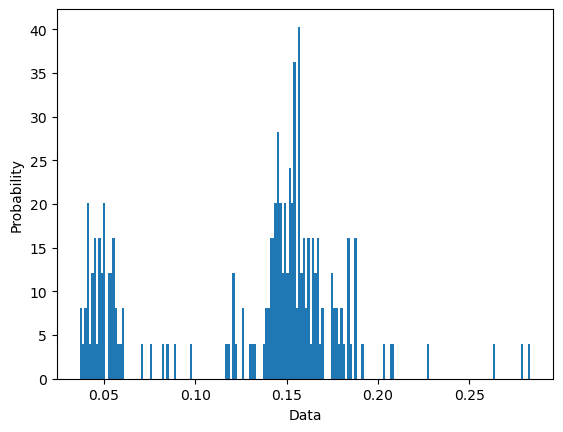

In [49]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=True, bins=192)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [63]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [60]:
def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [55]:
np

<module 'numpy' from '/usr/local/linux/miniforge-3.12/lib/python3.12/site-packages/numpy/__init__.py'>

In [64]:
results.sort(key=operator.attrgetter('score'), reverse=False)
interquartile_range(results)
n_sigma_rule(results, n=2)

0.1609013 0.075276904 0.24652568250894547
0.05273454 0.12999935 0.23546843230724335


[Result(source_node=(11, 15, 10), score=0.26351264),
 Result(source_node=(11, 15, 0), score=0.27941012),
 Result(source_node=(11, 15, 2), score=0.28352752)]

# One more iteration: Find maximally relevant source nodes to target nodes